# **Buyer Forecast on my Shopee Store**

This is a forecasting model of how many customers will order in my shop at a given month. This project is finished although the result was very underwhelming. I have no experience with dealing with timeseries data for sales forecasting and the data is not linear so this is just a trial run for my project. I will come back to this soon once I am experienced enough with time series data.

In [1]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
# Load data
sales_data = pd.read_csv('Shopee_Sales.csv')
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data


<ipython-input-8-7a349c146303>:3: UserWarning: Parsing '13/03/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales_data['Date'] = pd.to_datetime(sales_data['Date'])
<ipython-input-8-7a349c146303>:3: UserWarning: Parsing '14/03/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales_data['Date'] = pd.to_datetime(sales_data['Date'])
<ipython-input-8-7a349c146303>:3: UserWarning: Parsing '15/03/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales_data['Date'] = pd.to_datetime(sales_data['Date'])
<ipython-input-8-7a349c146303>:3: UserWarning: Parsing '16/03/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales_data['Date'] = pd.to_datetime(sales_data['Date'])
<ipython-input-8-7a349c146303>:3: UserWarning: Parsing '17/03/2021' in DD/MM/YYYY format. Provide fo

,Date,Visitors (Visit),Buyers (Placed Orders),Units (Placed Orders),Orders (Placed Orders),Sales (Placed Orders) (PHP),Conversion Rate (Visit to Placed),Buyers (Confirmed Orders),Units(Confirmed Orders),Orders (Confirmed Orders),Sales(Confirmed Orders) (PHP),Sales per Buyer (Confirmed Orders) (PHP),Conversion Rate,Conversion Rate (Placed to Confirmed)
0,2021-01-03,16,1,4,1,240,6.25%,1,4,1,240,240,6.25%,100.00%
1,2021-02-03,15,0,0,0,0,0.00%,0,0,0,0,0,0.00%,0.00%
2,2021-03-03,18,5,45,6,"1,888",27.78%,5,45,6,"1,888",377.6,27.78%,100.00%
3,2021-04-03,10,0,0,0,0,0.00%,0,0,0,0,0,0.00%,0.00%
4,2021-05-03,7,0,0,0,0,0.00%,0,0,0,0,0,0.00%,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-02-24,21,2,6,2,478,9.52%,2,6,2,478,239,9.52%,100.00%
726,2023-02-25,17,3,14,3,"1,133",17.65%,3,14,3,"1,133",377.67,17.65%,100.00%
727,2023-02-26,19,2,3,2,323,10.53%,2,3,2,323,161.5,10.53%,100.00%
728,2023-02-27,20,3,10,3,"2,013",15.00%,3,10,3,"2,013",671,15.00%,100.00%


Convert the data into monthly as the dataset has way to many zeros in daily and weekly sampling.

In [9]:
# Replace zeros with NaNs in the 'Sales(Confirmed Orders) (PHP)' column
sales_data['Sales(Confirmed Orders) (PHP)'] = sales_data['Sales(Confirmed Orders) (PHP)'].str.replace(',', '').astype(float).replace(0, np.nan)

# Aggregate the data to a higher level (e.g., weekly) to reduce the number of zero values
sales_data_monthly= sales_data.resample('M', on='Date').sum().reset_index()
sales_data_monthly = sales_data_monthly[sales_data_monthly['Date'] <= '2023-02-28']


In [10]:
# Set the index to the date column
sales_data_monthly = sales_data_monthly.set_index('Date')

sales_data_monthly

,Visitors (Visit),Buyers (Placed Orders),Units (Placed Orders),Orders (Placed Orders),Buyers (Confirmed Orders),Units(Confirmed Orders),Orders (Confirmed Orders),Sales(Confirmed Orders) (PHP)
Date,,,,,,,,
2021-01-31,272,19,116,19,20,120,20,7356.0
2021-02-28,203,26,118,28,26,118,28,7309.0
2021-03-31,410,42,266,45,42,263,43,13278.0
2021-04-30,373,39,285,39,37,281,37,14140.0
2021-05-31,367,40,336,40,39,331,39,17012.0
2021-06-30,245,19,123,21,18,117,18,6293.0
2021-07-31,366,33,256,36,33,247,33,12269.0
2021-08-31,448,45,327,48,44,323,47,17472.0
2021-09-30,578,39,267,43,37,255,37,12783.0


In [21]:
sales_data_monthly.to_csv('monthly.csv')

Visualize the data and it's information to see what's happening to the data.

In [11]:
print(sales_data_monthly.describe())

       Visitors (Visit)  Buyers (Placed Orders)  Units (Placed Orders)  \
count         26.000000               26.000000              26.000000   
mean         506.923077               52.500000             355.615385   
std          315.928083               20.613103             174.321789   
min          203.000000               19.000000             116.000000   
25%          366.250000               39.250000             265.250000   
50%          438.500000               50.000000             326.500000   
75%          507.000000               64.500000             425.750000   
max         1633.000000              104.000000             777.000000   

       Orders (Placed Orders)  Buyers (Confirmed Orders)  \
count               26.000000                  26.000000   
mean                55.423077                  51.230769   
std                 21.535409                  20.066505   
min                 19.000000                  18.000000   
25%                 40.750000    

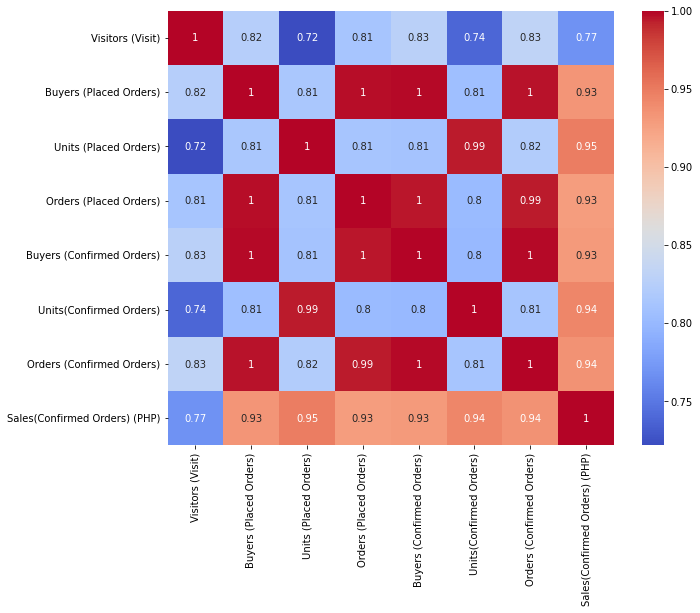

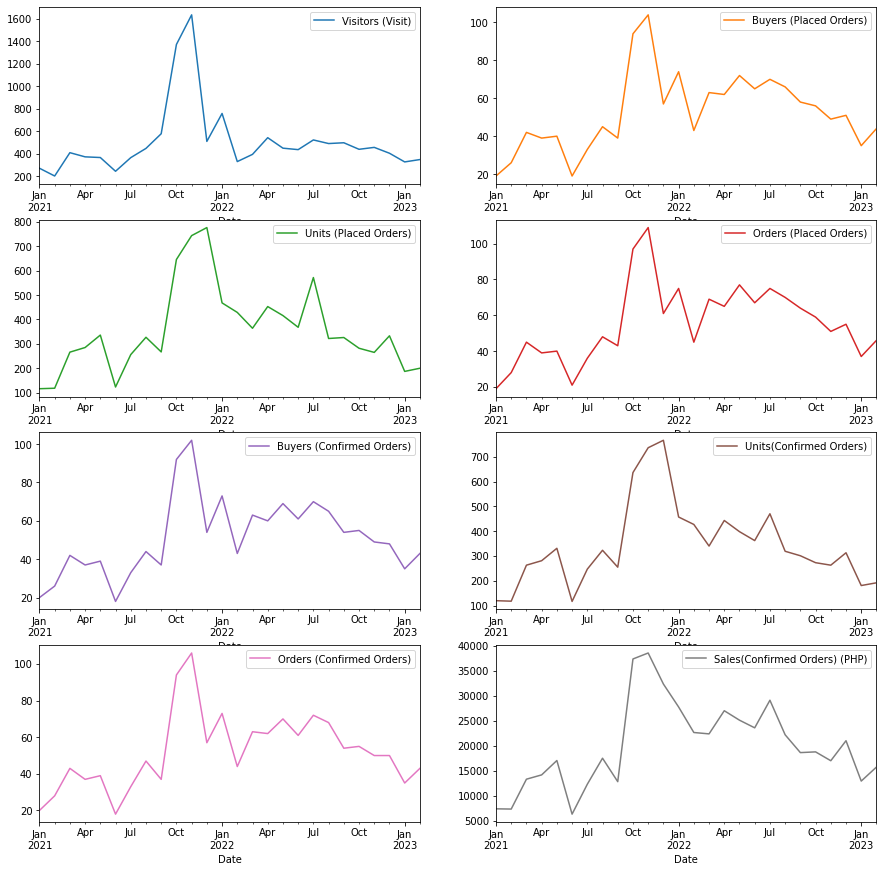

In [12]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(sales_data_monthly.corr(), annot=True, cmap="coolwarm")
plt.show()

# Time series plots
sales_data_monthly.plot(subplots=True, layout=(4, 2), figsize=(15, 15), sharex=False)
plt.show()

As seen on the graphs, the vizualization for colums look almost the same for every category with the highest during November 2021 when I used Shopee Ads

I will now check for the stationarity of all categories using ADF test.

In [14]:
from statsmodels.tsa.stattools import adfuller
# ADF test function
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Check stationarity for each column
for col in sales_data_monthly.columns:
    print(f'\nADF Test for {col}:')
    adf_test(sales_data_monthly[col])


ADF Test for Visitors (Visit):
ADF Statistic: -2.7339983144880935
p-value: 0.06833757320577542
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

ADF Test for Buyers (Placed Orders):
ADF Statistic: -2.858692679926383
p-value: 0.050366656528128974
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

ADF Test for Units (Placed Orders):
ADF Statistic: -2.346157489471375
p-value: 0.15751291256042893
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

ADF Test for Orders (Placed Orders):
ADF Statistic: -2.8201395010856705
p-value: 0.05545407140627111
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

ADF Test for Buyers (Confirmed Orders):
ADF Statistic: -2.9296405466900497
p-value: 0.042008185883002064
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

ADF Test for Units(Confirmed Orders):
ADF Statistic: -2.2172717291305934
p-value: 0.20003664052365766
Critical Va

Based on the results only Buyers (Confirmed Orders) is stationary so we will push on with that category.

I will divide the training to the first 20 months of the data and the test set for the last 6 months to test the predictions of the model.

In [15]:
train = sales_data_monthly['Buyers (Confirmed Orders)'][:20]
test = sales_data_monthly['Buyers (Confirmed Orders)'][20:]

I will use pmdarima module to make adjusting the parameters and ARIMA model more convenient for me.

In [16]:
import pmdarima as pm
# Find the best ARIMA model
best_model = pm.auto_arima(train, suppress_warnings=True, seasonal=False,
                           stepwise=True, trace=True,
                           start_p=0, max_p=5,
                           start_d=0, max_d=2,
                           start_q=0, max_q=5)

print(f'Best ARIMA model: {best_model.order}')

# Make forecasts
forecast = best_model.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=173.660, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=173.094, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=171.900, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.386 seconds
Best ARIMA model: (0, 1, 0)


**Visualize the result**

ARIMA MAE: 17.666666666666668


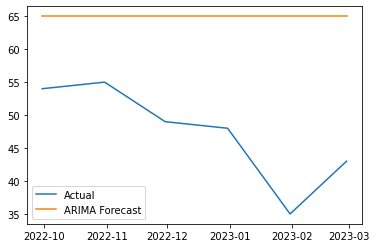

In [17]:
# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(test, forecast)
print(f'ARIMA MAE: {mae}')

# Plot the actual values vs. the ARIMA forecast
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

Based on the graph, it looks like the model did not do well with forecasting the test data.

Let's move on with FB Prophet

In [18]:
# Prepare data for fbprophet
prophet_data = train.reset_index()
prophet_data.columns = ['ds', 'y']

# Fit the model
model_prophet = Prophet()
model_prophet.fit(prophet_data)

# Make forecasts
future = model_prophet.make_future_dataframe(periods=len(test), freq='M')
prophet_forecast = model_prophet.predict(future)

# Extract the forecasted values for test data
prophet_forecast = prophet_forecast['yhat'][20:].values

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp25kt3rl7/eary17cq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp25kt3rl7/rbl2ttws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12374', 'data', 'file=/tmp/tmp25kt3rl7/eary17cq.json', 'init=/tmp/tmp25kt3rl7/rbl2ttws.json', 'output', 'file=/tmp/tmp25kt3rl7/prophet_modelrio8q7lx/prophet_model-20230317050615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:06:15 - cmdstanpy - INFO - Chain [1] start processing
IN

In [19]:
mse_arima = mean_squared_error(test, forecast)
mse_prophet = mean_squared_error(test, prophet_forecast)

print(f'MSE for ARIMA: {mse_arima}')
print(f'MSE for fbprophet: {mse_prophet}')

MSE for ARIMA: 358.3333333333333
MSE for fbprophet: 1442.5216363857305


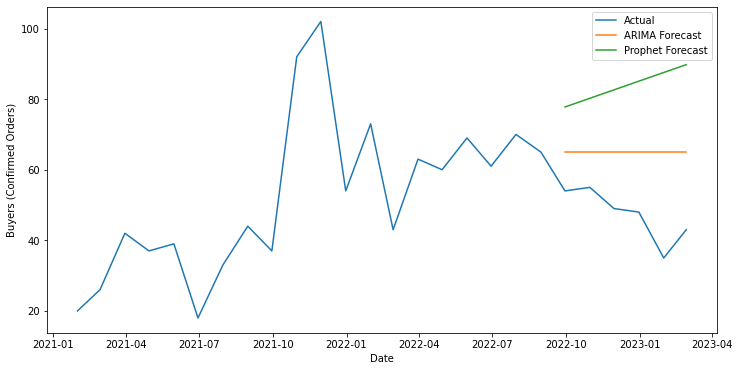

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sales_data_monthly.index, sales_data_monthly['Buyers (Confirmed Orders)'], label='Actual')
plt.plot(sales_data_monthly.index[20:], forecast, label='ARIMA Forecast')
plt.plot(sales_data_monthly.index[20:], prophet_forecast, label='Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Buyers (Confirmed Orders)')
plt.legend()
plt.show()

Based on the metrics and the graph it looks like both the models are not performing too well but ARIMA is performing better compared to Prophet.

## **Key Takes**

Based on the data and what I learned from it, it looks like I need more data from my sales in shopee and also I need to study more about time series data.